## survey results

In [ ]:
import pandas as pd 
import io
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
DATA_FILE   = "../output/survey_results/all_participants_ratings.csv"        # original wide file
OUTPUT_DIR  = Path("../output/survey_results")   

def load_data(csv_path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    likert_cols = [c for c in df.columns if c != "participant"]
    df[likert_cols] = df[likert_cols].astype(int)
    return df

def make_item_text_table() -> pd.DataFrame:
    items = [
        ("U1", "Usability",
         "I found the chatbot easy to use."),
        ("U2", "Usability",
         "Interacting with the chatbot was clear and understandable."),
        ("U3", "Usability",
         "The chatbot responded quickly to my inputs."),
        ("U4", "Usability",
         "I would like to use this chatbot regularly."),
        ("U5", "Usability",
         "I was able to start using the chatbot right away."),
        ("T1", "Trust",
         "I trusted the information provided by the chatbot."),
        ("T2", "Trust",
         "The chatbot clearly indicated when it was uncertain."),
        ("T3", "Trust",
         "I trusted the chatbot to tell me when it was unsure."),
        ("T4", "Trust",
         "Seeing the chatbot’s confidence score affected how much I relied on its answers."),
        ("T5", "Trust",
         "The sources provided by the chatbot helped me verify its answers."),
    ]
    return pd.DataFrame(items, columns=["code", "section", "statement"])

def to_long(df_wide: pd.DataFrame, items_df: pd.DataFrame) -> pd.DataFrame:
    return (
        df_wide.melt(id_vars="participant", var_name="code", value_name="score")
               .merge(items_df, on="code")
               .loc[:, ["participant", "section", "code", "statement", "score"]]
    )

# wrangle csv's
df_wide = load_data(DATA_FILE)

items_df = make_item_text_table()
items_df.to_csv(OUTPUT_DIR / "likert_items.csv", index=False)

long_df = to_long(df_wide, items_df)
long_df.to_csv(OUTPUT_DIR / "chatbot_survey_long.csv", index=False)

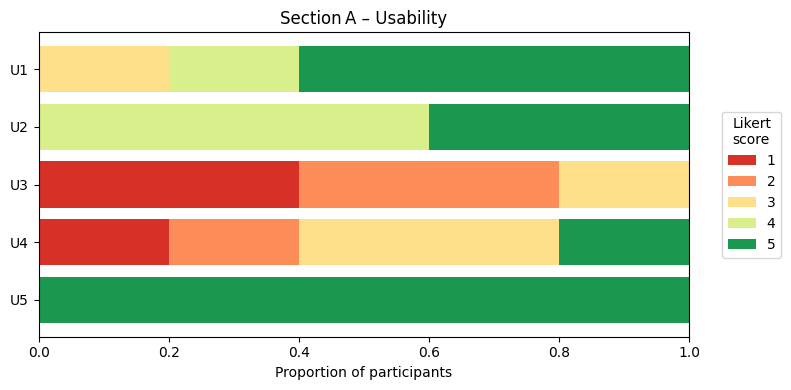

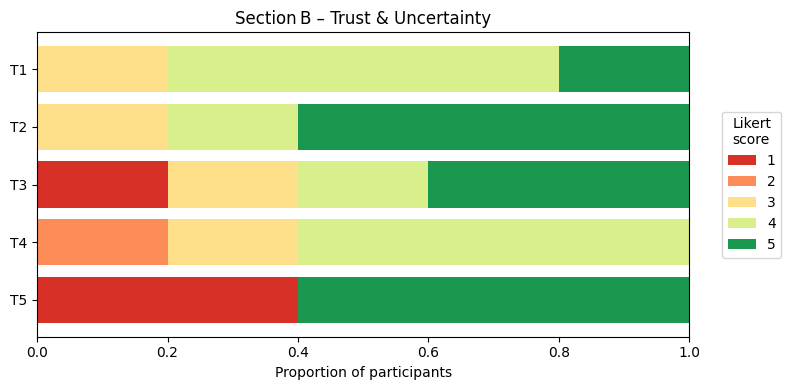

In [26]:

def item_summary(df_wide: pd.DataFrame, codes: list[str]) -> pd.DataFrame:
    rows = []
    for col in codes:
        cnt = (df_wide[col]
               .value_counts()
               .reindex([1, 2, 3, 4, 5], fill_value=0))
        rows.append({
            "item": col,
            **{f"n{sc}": cnt.loc[sc] for sc in cnt.index},
            "median": df_wide[col].median(),
            "mode":   df_wide[col].mode().iat[0],
        })
    return pd.DataFrame(rows)

def plot_stacked_bar(df_wide: pd.DataFrame,
                     codes: list[str],
                     title: str,
                     colors=None,
                     fname: str | None = None):
    if colors is None:  # red → green gradient
        colors = ["#d73027", "#fc8d59", "#fee08b", "#d9ef8b", "#1a9850"]
    codes = codes[::-1]          # 1 at top, 5 at bottom
    prop = pd.DataFrame([
        (df_wide[c].value_counts()
                  .reindex([1, 2, 3, 4, 5], fill_value=0).values / len(df_wide))
        for c in codes
    ], index=codes, columns=[1, 2, 3, 4, 5])

    plt.figure(figsize=(8, 4))
    left = pd.Series([0]*len(prop), index=prop.index)
    for score, col in zip([1, 2, 3, 4, 5], colors):
        plt.barh(prop.index, prop[score], left=left,
                 label=score, color=col)
        left += prop[score]

    #plt.yticks([])      # blank labels 
    plt.xlim(0, 1)
    plt.xlabel("Proportion of participants")
    plt.title(title)
    plt.legend(title="Likert\nscore", bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()


us_codes  = ["U1", "U2", "U3", "U4", "U5"]
tr_codes  = ["T1", "T2", "T3", "T4", "T5"]

us_item = item_summary(df_wide, us_codes)
us_item.to_csv(OUTPUT_DIR / "usability_item_summary.csv", index=False)
tr_item = item_summary(df_wide, tr_codes)
tr_item.to_csv(OUTPUT_DIR / "trust_item_summary.csv",index=False)

plot_stacked_bar(df_wide, us_codes,
                 "Section A – Usability",
                 fname=OUTPUT_DIR / "lab_usability_stacked.png")
plot_stacked_bar(df_wide, tr_codes,
                 "Section B – Trust & Uncertainty",
                 fname=OUTPUT_DIR / "lab_trust_stacked.png")


In [28]:
import numpy as np

# Define which items belong to each section
usability_items = ["U1", "U2", "U3", "U4", "U5"]
trust_items     = ["T1", "T2", "T3", "T4", "T5"]

# Compute per-participant averages (section scores)
df_wide["usability_score"] = df_wide[usability_items].mean(axis=1)
df_wide["trust_score"]     = df_wide[trust_items].mean(axis=1)

# Calculate group-level summary stats
us_median = df_wide["usability_score"].median()
us_iqr    = np.subtract(*np.percentile(df_wide["usability_score"], [75, 25]))

tr_median = df_wide["trust_score"].median()
tr_iqr    = np.subtract(*np.percentile(df_wide["trust_score"], [75, 25]))

print(f"Usability – Median: {us_median:.2f}, IQR: {us_iqr:.2f}")
print(f"Trust     – Median: {tr_median:.2f}, IQR: {tr_iqr:.2f}")


Usability – Median: 3.60, IQR: 0.40
Trust     – Median: 3.60, IQR: 0.80
